**Description**: Tries to answer [my answer on
stats.stackexchange.com](https://stats.stackexchange.com/q/611877/337906). This
meta-analysis suggests that pretraining on test set features (no labels) can be okay.

**Estimated runtime**: ~1 hour (Multi-core isn't working on my machine. Set
`cores=4` in the `model.fit` call if it works for you.)

TODO: see if this can be run on a GPU.

Note: I'm still learning how to do this type of analysis.

In [1]:
import os

import arviz as az
import bambi as bmb
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

# Load data

In [3]:
ACCURACIES_DIR = os.path.join("accuracies_from_paper", "gpt2")

_dfs = []
for dataset in sorted(os.listdir(ACCURACIES_DIR)):
    _df = pd.read_csv(os.path.join(ACCURACIES_DIR, dataset, "accuracies.csv"))
    _df["dataset"] = dataset
    _dfs.append(_df)
accuracy_df = pd.concat(_dfs)
accuracy_df = accuracy_df[["dataset", "base", "extra", "test"]]

In [4]:
num_test = 200  # taken from bert/run.ipynb
num_correct_df = (accuracy_df.copy()[["base", "extra", "test"]] * num_test).astype(int, errors="raise")
num_correct_df["dataset"] = accuracy_df["dataset"].copy()
num_correct_df = num_correct_df[["dataset", "base", "extra", "test"]]
num_correct_df["pair"] = range(len(num_correct_df))
num_correct_df

,dataset,base,extra,test,pair
0,ag_news,114,110,117,0
1,ag_news,107,111,114,1
2,ag_news,98,94,102,2
3,ag_news,92,142,131,3
4,ag_news,95,122,117,4
...,...,...,...,...,...
45,yelp_review_full,49,52,63,695
46,yelp_review_full,61,68,68,696
47,yelp_review_full,59,68,68,697
48,yelp_review_full,44,39,52,698


# Model

A multilevel model is fit:

$$
\begin{align*}
Y_{ijk} \sim \text{Poisson}(\lambda_{ijk}) && \text{number of correct predictions} \\
\log(\lambda_{ijk}) = \mu + U_i + V_{ij} + \beta x_{ijk} && \text{additive effects} \\
\mu \sim \text{Normal}(0, 3.5355) && \text{prior for intercept} \\
U_i \sim \text{Normal}(0, \sigma_{D}) && \text{effect of dataset} \\
V_{ij} \sim \text{Normal}(0, \sigma_{V}) && \text{(nested) effect of dataset subsample (AKA pair)} \\
\beta \sim \text{Normal}(0, 5) && \text{prior for main effect} \\
\sigma_{D}, \sigma_{V} \sim \text{HalfNormal}(0, 3.5355) && \text{prior for standard deviations}.
\end{align*}
$$

$i = 1, 2, \dots, 14$ for the dataset.

$j = 1, 2, \dots, 50$ for the subsample of dataset $i$.

$k = 1, 2$ for control and treatment.

$x_{ijk} = 0$ if $k = 1$ else it's $1$. We'll perform inference on $\beta$ via MCMC.

# Analysis code

In [5]:
def violin_plot(
    accuracy_df: pd.DataFrame,
    paired_diff_column: str,
    title: str,
    color,
    **ylabel_kwargs
):
    _, axes = plt.subplots(figsize=(16, 2))
    axes: plt.Axes
    sns.violinplot(
        data=accuracy_df, x="dataset", y=paired_diff_column, ax=axes, color=color
    )
    plt.axhline(0, linestyle="dashed", color="gray")
    axes.set_title(title)
    axes.yaxis.grid(True)
    axes.set_xlabel("Text classification dataset")
    axes.set_ylabel(**ylabel_kwargs)
    plt.xticks(rotation=45, ha="right")
    plt.show()

In [6]:
def eda(
    accuracy_df: pd.DataFrame,
    control_column: str,
    treatment_column: str,
    title: str,
    color,
    **ylabel_kwargs,
):
    accuracy_df = accuracy_df.copy()
    paired_diff_column = f"{treatment_column} - {control_column}"
    accuracy_df[paired_diff_column] = (
        accuracy_df[treatment_column] - accuracy_df[control_column]
    )
    violin_plot(accuracy_df, paired_diff_column, title, color, **ylabel_kwargs)
    # fmt: off
    summary = (
        accuracy_df
        .groupby("dataset")
        [paired_diff_column]
        .describe()
        [["mean", "std"]]
    )
    # fmt: on
    print(summary.mean())
    return summary.round(3)

In [7]:
def model(
    num_correct_df: pd.DataFrame, control_column: str, treatment_column: str
) -> tuple[bmb.Model, az.InferenceData]:
    df = (
        num_correct_df[["pair", "dataset", control_column, treatment_column]]
        .melt(["pair", "dataset"], var_name="method", value_name="num_correct")
        .sort_values("pair")
        .reset_index(drop=True)
    )
    # Pairs/subsamples were formed from the dataset. So it's nested, not crossed
    model = bmb.Model(
        "num_correct ~ method + (1|dataset/pair)", family="poisson", data=df
    )
    inference_method = "mcmc" if not torch.cuda.is_available() else "nuts_numpyro"
    fit_summary: az.InferenceData = model.fit(
        cores=1, inference_method=inference_method, chains=2, random_seed=123
    )
    az_summary: pd.DataFrame = az.summary(fit_summary)
    display(
        az_summary.loc[
            [index_name for index_name in az_summary.index if "method" in index_name]
        ]
    )

    az.plot_trace(fit_summary, compact=False, var_names="method", filter_vars="like")
    return model, fit_summary

# Does pretraining help?

This is our control.

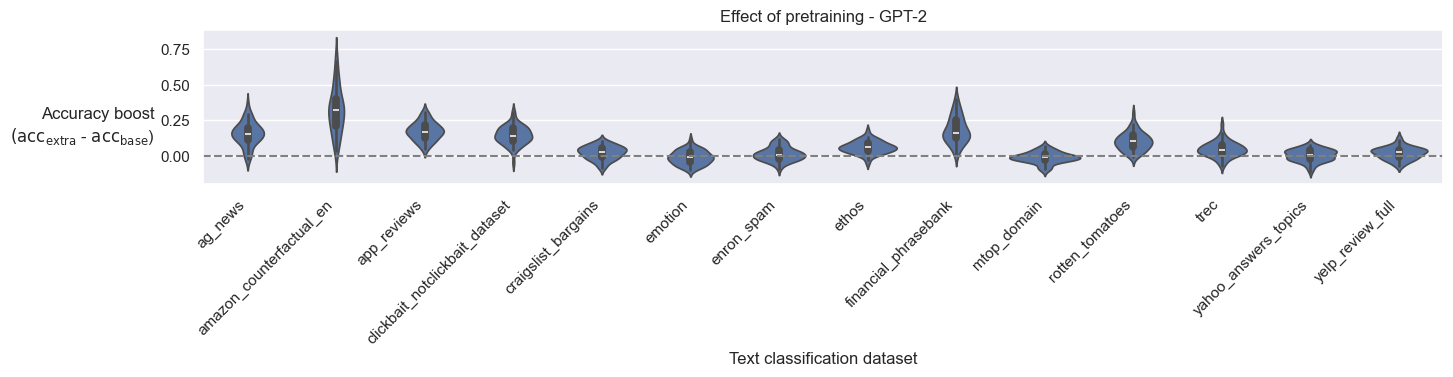

mean    0.089186
std     0.063915
dtype: float64


,mean,std
dataset,,
ag_news,0.157,0.083
amazon_counterfactual_en,0.321,0.159
app_reviews,0.175,0.064
clickbait_notclickbait_dataset,0.148,0.065
craigslist_bargains,0.024,0.047
emotion,-0.009,0.048
enron_spam,0.015,0.048
ethos,0.062,0.044
financial_phrasebank,0.186,0.094


In [8]:
eda(
    accuracy_df,
    control_column="base",
    treatment_column="extra",
    title="Effect of pretraining - GPT-2",
    color=None,
    ylabel=(
        "Accuracy boost\n$(\\text{acc}_\\text{extra}$ - $\\text{acc}_\\text{base}$)"
    ),
    rotation="horizontal",
    ha="right",
    va="top",
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, method, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 641 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[extra],0.223,0.006,0.213,0.234,0.0,0.0,5474.0,1557.0,1.0


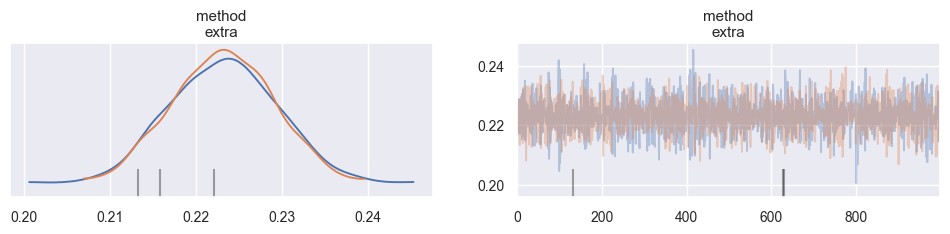

In [9]:
model_control, summary_control = model(
    num_correct_df, control_column="base", treatment_column="extra"
)

In [10]:
print(model_control)

       Formula: num_correct ~ method + (1|dataset/pair)
        Family: poisson
          Link: mu = log
  Observations: 1400
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 3.5355)
            method ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


Solid evidence that pretraining helps. There's an effect to detect.

# Does pretraining on test cause bias?

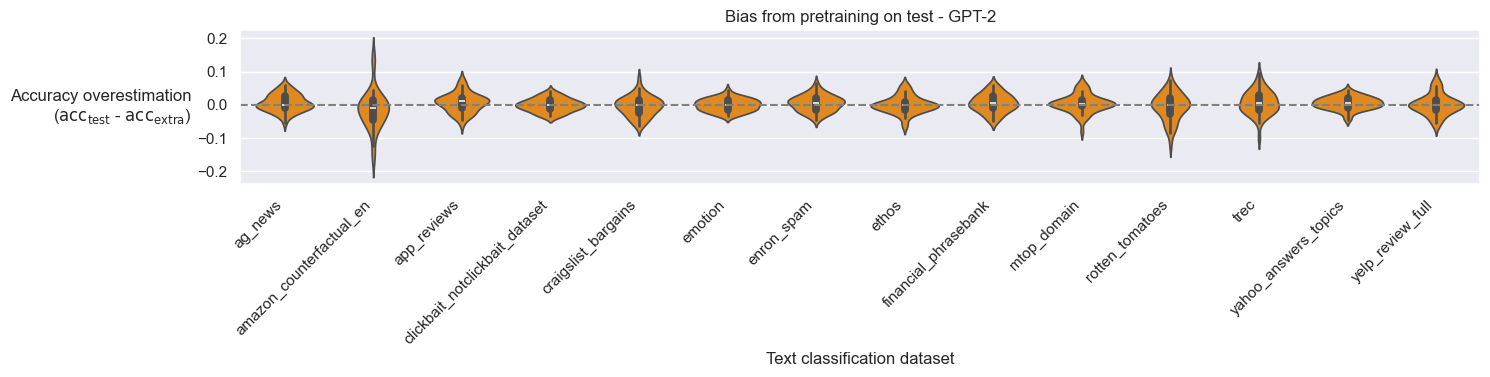

mean    0.001129
std     0.029550
dtype: float64


,mean,std
dataset,,
ag_news,0.006,0.026
amazon_counterfactual_en,-0.015,0.059
app_reviews,0.007,0.029
clickbait_notclickbait_dataset,-0.001,0.020
craigslist_bargains,-0.004,0.030
emotion,-0.000,0.019
enron_spam,0.005,0.024
ethos,0.000,0.026
financial_phrasebank,0.005,0.028


In [11]:
eda(
    accuracy_df,
    control_column="extra",
    treatment_column="test",
    title="Bias from pretraining on test - GPT-2",
    color="darkorange",
    ylabel=(
        "Accuracy overestimation\n"
        "($\\text{acc}_\\text{test}$ - $\\text{acc}_\\text{extra}$)"
    ),
    rotation="horizontal",
    ha="right",
    va="center",
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, method, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 641 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[test],0.003,0.006,-0.007,0.013,0.0,0.0,4834.0,1282.0,1.0


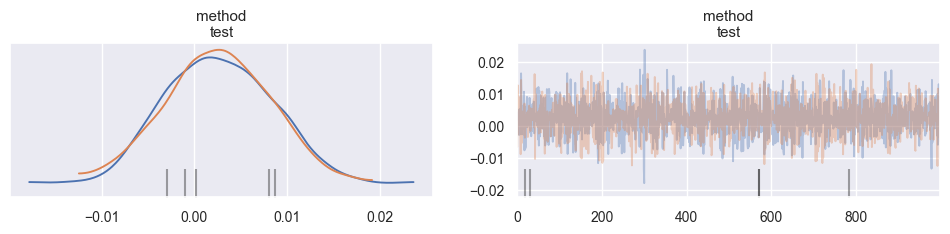

In [12]:
model_bias, summary_bias = model(
    num_correct_df, control_column="extra", treatment_column="test"
)

In [13]:
print(model_bias)

       Formula: num_correct ~ method + (1|dataset/pair)
        Family: poisson
          Link: mu = log
  Observations: 1400
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 3.5355)
            method ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


GPT-2: Not good evidence of a bias: $e^{0.003} - 1 \times 100\% \approx 0.3\%$ relative
increase in accuracy.

BERT: There's evidence of a tiny bias (almost all of the posterior mass is on the right
side): $e^{0.009} - 1 \times 100\% \approx 1\%$ relative increase in accuracy.

I'll re-analyze the combined data, stratifying by model.